In [1]:
import autograd.numpy as np
from autograd.misc.flatten import flatten_func
from autograd import grad
import matplotlib.pyplot as plt

## Problem 1 (13.4)

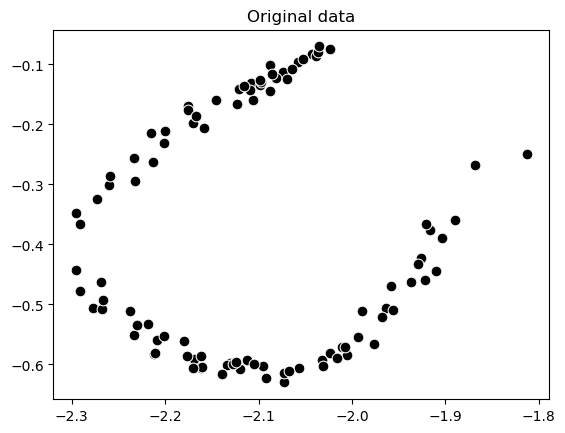

In [2]:
# import data
X = np.loadtxt('universal_autoencoder_samples.csv', delimiter=',')

plt.scatter(X[0,:], X[1,:], c = 'k', s = 60, linewidth = 0.75, edgecolor = 'w')
plt.title("Original data")
plt.show()

In [3]:
x_mean = np.mean(X[0])
x_std = np.std(X[0])
y_mean = np.mean(X[1])
y_std = np.std(X[1])
X[0] = (X[0] - x_mean)/x_std
X[1] = (X[1] - y_mean)/y_std

In [4]:
activation = np.tanh

In [5]:
def feature_transforms(a, w):
    for W in w:

        # compute inner-product with current layer weights
        a = W[0] + np.dot(a.T, W[1:])

        # pass through activation
        a = activation(a).T
    
    return a

In [6]:
# neural network model
def model(x, theta):
    # compute feature transformation
    f = feature_transforms(x, theta[0])

    # compute final linear combination
    a = theta[1][0] + np.dot(f.T, theta[1][1:])

    return a.T

In [7]:
# create initial weights for a neural network model
def network_initializer(layer_sizes, scale):

    # container for all tunable weights
    weights = []

    # create appropriately -sized initial weight matrix for each layer of network
    for k in range(len(layer_sizes)-1):

        # get layer sizes for current weight matrix
        U_k = layer_sizes[k]
        U_k_plus_1 = layer_sizes[k+1]

        # make weight matrix
        weight = scale*np.random.randn(U_k+1, U_k_plus_1)
        weights.append(weight)

    # repackage weights so that theta_init[0] contains all
    # weight matrices internal to the network, and theta_init[1]
    # contains final linear combination weights
    theta_init = [weights[:-1], weights[-1]]

    return theta_init

In [8]:
def least_squares_auto(w):
    w_e = w[0]
    w_d = w[1]
    decoded = model(model(X, w_e), w_d)
    return np.mean((decoded[0] - X[0])**2 + (decoded[1] - X[1])**2)

In [9]:
def gradient_descent(g, alpha, max_its, w):
    weight_history = [w]
    cost_history = [g(w)]

    g_flat, unflatten, w = flatten_func(g, w)
    gradient = grad(g_flat)

    for k in range(max_its):
        grad_eval = gradient(w)

        w = w - alpha*grad_eval

        weight_history.append(unflatten(w))
        cost_history.append(g(unflatten(w)))

    return weight_history, cost_history
    

In [10]:
layer_sizes = [2, 10, 10, 10, 2]
theta_e = network_initializer(layer_sizes, .5)
theta_d = network_initializer(layer_sizes, .5)

In [11]:
alpha = 0.04
num_iter = 100
theta = [theta_e, theta_d]
weight_history, cost_history = gradient_descent(least_squares_auto, alpha, num_iter, theta)

Text(0, 0.5, 'Cost')

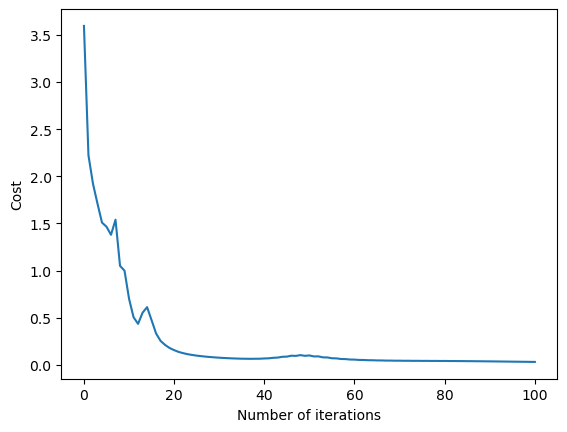

In [12]:
plt.plot(cost_history)
plt.xlabel("Number of iterations")
plt.ylabel("Cost")

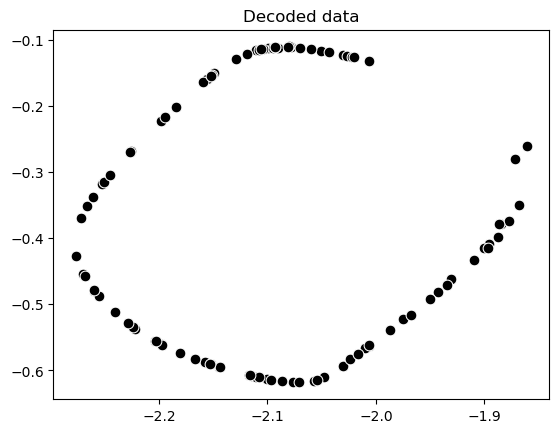

In [13]:
decodedX = model(model(X, weight_history[num_iter][0]), weight_history[num_iter][1])
decodedX[0] = (decodedX[0]*x_std) + x_mean
decodedX[1] = (decodedX[1]*y_std) + y_mean
plt.scatter(decodedX[0,:], decodedX[1,:], c = 'k', s = 60, linewidth = 0.75, edgecolor = 'w')
plt.title("Decoded data")
plt.show()

We can see from the scatterplot of the decoded data that our learned manifold closely resembles the original data

## Problem 2 (13.8)

In [14]:
# get MNIST data from online repository
from sklearn.datasets import fetch_openml
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# convert string labels to integers
y = np.array([int(v) for v in y])[:,np.newaxis]

print(np.shape(x))
print(np.shape(y))

(70000, 784)
(70000, 1)


In [15]:
x = np.array(x.transpose())
y = np.array(y.transpose())
print(np.shape(x))
print(np.shape(y))

(784, 70000)
(1, 70000)


In [16]:
selected_indices = np.random.choice(range(70000), size=50000, replace=False)
x = x[:,selected_indices]
y = y[:,selected_indices]

In [17]:
print(np.shape(x))
print(np.shape(y))

(784, 50000)
(1, 50000)


In [18]:
def normalize(input):
    output = []
    for i in range(np.shape(input)[0]):
        if np.std(input[i]) != 0:
            output.append((input[i] - np.mean(input[i]))/np.std(input[i]))
        else:
            output.append(input[i] - np.mean(input[i]))
    return np.array(output)

In [19]:
x = normalize(x)

In [20]:
def activation(a):
    return np.maximum(0, a)

In [21]:
layer_sizes = [784, 10, 10, 10, 10, 10]
theta = network_initializer(layer_sizes, .1)

In [22]:
def multi_softmax(w, indices):
    x_cur = x[:, indices]
    y_cur = y[:, indices]

    model_output = model(x_cur,w)
    return np.mean(np.log(np.sum(np.exp(model_output), axis=0)) - np.array([model_output[int(y_cur[0][i]), i] for i in range(len(y_cur[0]))]))

In [23]:
def gradient_descent_minibatch(g, alpha, max_its, w, batch_size):
    weight_history = [w]
    cost_history = [g(w, range(np.shape(x)[1]))]

    g_flat, unflatten, w = flatten_func(g, w)
    gradient = grad(g_flat)

    for k in range(max_its):
        start_idx = 0
        while start_idx < np.shape(x)[1]:
            batch_inds = range(start_idx, start_idx+batch_size)

            grad_eval = gradient(w, batch_inds)

            w = w-alpha*grad_eval

            start_idx += batch_size

        weight_history.append(unflatten(w))
        cost_history.append(g(unflatten(w), range(np.shape(x)[1])))

    return weight_history, cost_history

In [24]:
alpha = 1
num_iter = 10
weight_history, cost_history = gradient_descent_minibatch(multi_softmax, alpha, num_iter, theta, 500)

In [25]:
def feature_transforms2(a, w):
    for W in w:

        # compute inner-product with current layer weights
        a = W[0] + np.dot(a.T, W[1:])

        # pass through activation
        a = activation(a).T

        # normalize
        a = normalize(a)
    
    return a

In [26]:
# neural network model
def model2(x, theta):
    # compute feature transformation
    f = feature_transforms2(x, theta[0])

    # compute final linear combination
    a = theta[1][0] + np.dot(f.T, theta[1][1:])

    return a.T

In [27]:
def multi_softmax2(w, indices):
    x_cur = x[:, indices]
    y_cur = y[:, indices]

    model_output = model2(x_cur,w)
    return np.mean(np.log(np.sum(np.exp(model_output), axis=0)) - np.array([model_output[int(y_cur[0][i]), i] for i in range(len(y_cur[0]))]))

In [28]:
weight_history2, cost_history2 = gradient_descent_minibatch(multi_softmax2, alpha, num_iter, theta, 500)

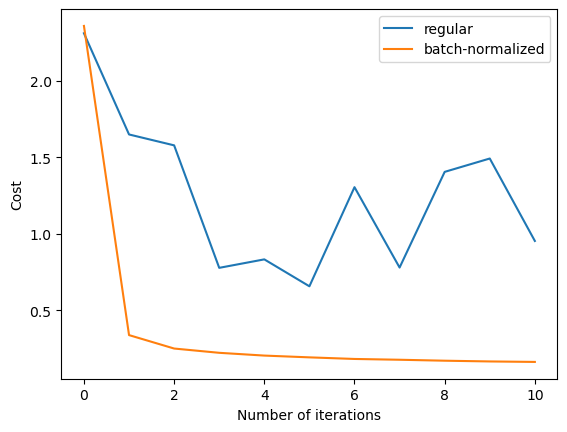

In [29]:
plt.plot(cost_history, label="regular")
plt.plot(cost_history2, label="batch-normalized")
plt.xlabel("Number of iterations")
plt.ylabel("Cost")
plt.legend()
plt.show()

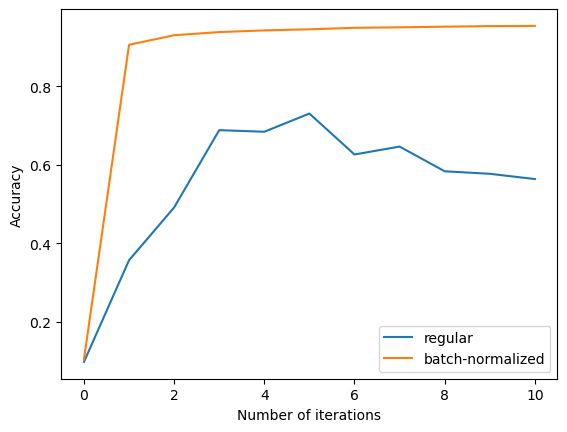

In [30]:
plt.plot([np.sum(np.equal(np.argmax(model(x, w), axis=0), y))/np.size(y) for w in weight_history], label="regular")
plt.plot([np.sum(np.equal(np.argmax(model2(x, w), axis=0), y))/np.size(y) for w in weight_history2], label="batch-normalized")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

The plots above look similar to the ones provided in the text

 ## Problem 3 (13.9)

In [87]:
# load in dataset
csvname = 'noisy_sin_sample.csv'
data = np.loadtxt(csvname, delimiter = ',')
x = data[:-1,:]
y = data[-1:,:]

print(np.shape(x))
print(np.shape(y))

(1, 21)
(1, 21)


In [88]:
x_mean = np.mean(x)
x_std = np.std(x)
x[0] = (x[0] - x_mean)/x_std

x_orig = x
y_orig = y

In [89]:
train_indices = np.random.choice(range(21), size=14, replace=False)

x_val = np.delete(x_orig, train_indices, axis=1)
y_val = np.delete(y_orig, train_indices, axis=1)
x = x_orig[:,train_indices]
y = y_orig[:,train_indices]

print(np.shape(x_orig))
print(np.shape(y_orig))
print(np.shape(x_val))
print(np.shape(y_val))
print(np.shape(x))
print(np.shape(y))

(1, 21)
(1, 21)
(1, 7)
(1, 7)
(1, 14)
(1, 14)


In [90]:
activation = np.tanh

In [91]:
layer_sizes = [1, 10, 10, 10, 1]
theta = network_initializer(layer_sizes, .1)

In [92]:
def mse(w, x=x, y=y):
    model_output = model(x, w)
    return np.mean(np.square(y - model_output))

In [93]:
def gradient_descent_val(g, alpha, max_its, w):
    weight_history = [w]
    cost_history = [g(w)]

    min_val_weights = w
    min_val_cost = g(w, x_val, y_val)
    min_val_iter = 0
    val_cost_history = [g(w, x_val, y_val)]

    g_flat, unflatten, w = flatten_func(g, w)
    gradient = grad(g_flat)

    for k in range(max_its):
        grad_eval = gradient(w)

        w = w - alpha*grad_eval

        weight_history.append(unflatten(w))
        cost_history.append(g(unflatten(w)))

        cur_val_cost = g(unflatten(w), x_val, y_val)
        val_cost_history.append(cur_val_cost)
        if cur_val_cost < min_val_cost:
            min_val_cost = cur_val_cost
            min_val_weights = unflatten(w)
            min_val_iter = k

    return weight_history, cost_history, min_val_weights, min_val_cost, min_val_iter, val_cost_history

In [94]:
alpha = .02
num_iter = 10000
weight_history, cost_history, min_val_weights, min_val_cost, min_val_iter, val_cost_history = gradient_descent_val(mse, alpha, num_iter, theta)

In [95]:
print(min_val_iter)

232


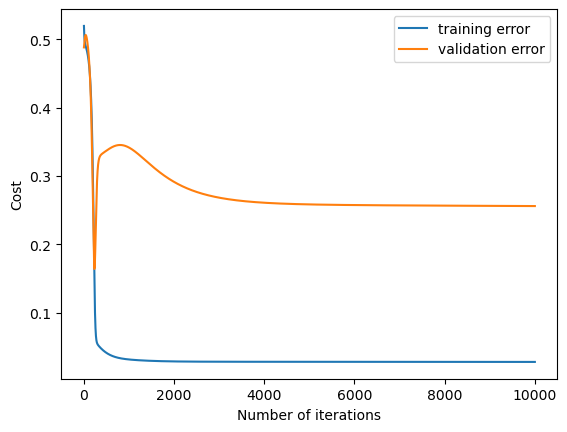

In [96]:
plt.plot(cost_history, label="training error")
plt.plot(val_cost_history, label="validation error")
plt.legend()
plt.xlabel("Number of iterations")
plt.ylabel("Cost")
plt.show()

In [97]:
model_input = np.array([np.arange(-2, 2, .1)])

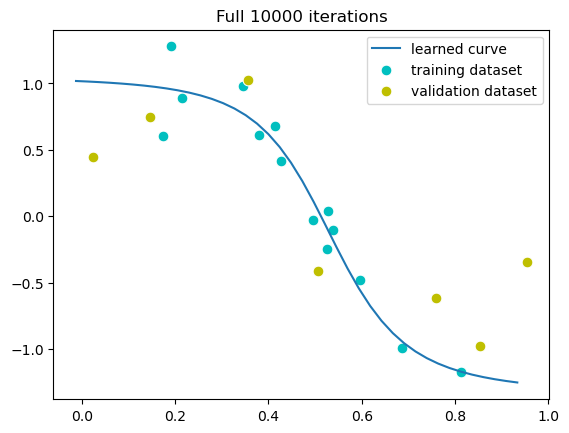

In [98]:
model_output = model(model_input, weight_history[num_iter])
model_xplot = (model_input*x_std) + x_mean
x_plot = (x*x_std) + x_mean
x_val_plot = (x_val*x_std) + x_mean
plt.plot(model_xplot[0], model_output[0], label="learned curve")
plt.scatter(x_plot, y, c = 'c', s = 60, linewidth = 0.75, edgecolor = 'w', label="training dataset")
plt.scatter(x_val_plot, y_val, c = 'y', s = 60, linewidth = 0.75, edgecolor = 'w', label="validation dataset")
plt.title(f"Full {num_iter} iterations")
plt.legend()
plt.show()

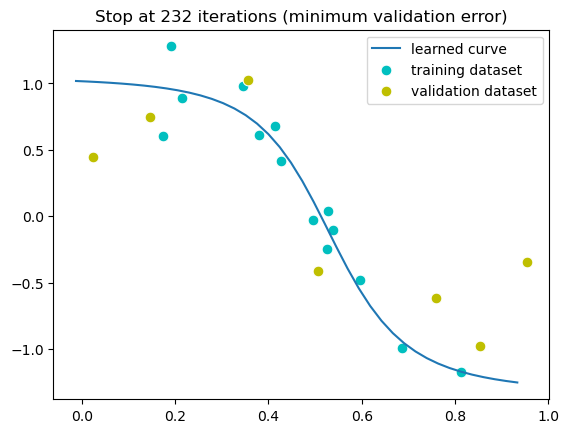

In [99]:
early_model_output = model(model_input, min_val_weights)
plt.plot(model_xplot[0], model_output[0], label="learned curve")
plt.scatter(x_plot, y, c = 'c', s = 60, linewidth = 0.75, edgecolor = 'w', label="training dataset")
plt.scatter(x_val_plot, y_val, c = 'y', s = 60, linewidth = 0.75, edgecolor = 'w', label="validation dataset")
plt.title(f"Stop at {min_val_iter} iterations (minimum validation error)")
plt.legend()
plt.show()

The plots above look similar to the ones provided in the text

## Problem 4 (13.10)

In [100]:
# get MNIST data from online repository
from sklearn.datasets import fetch_openml
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# convert string labels to integers
y = np.array([int(v) for v in y])[:,np.newaxis]

print(np.shape(x))
print(np.shape(y))

(70000, 784)
(70000, 1)


In [101]:
x = np.array(x.transpose())
y = np.array(y.transpose())
print(np.shape(x))
print(np.shape(y))

(784, 70000)
(1, 70000)


In [102]:
selected_indices = np.random.choice(range(70000), size=60000, replace=False)
x = x[:,selected_indices]
y = y[:,selected_indices]

In [103]:
x=normalize(x)

In [104]:
train_indices = np.random.choice(range(60000), size=50000, replace=False)
val_indices = np.delete(range(60000), train_indices)
print(np.shape(val_indices))
print(np.shape(train_indices))

(10000,)
(50000,)


In [105]:
def activation(a):
    return np.maximum(0, a)

In [106]:
layer_sizes = [784, 100, 100, 10]
theta = network_initializer(layer_sizes, .1)

In [107]:
def gradient_descent_minibatch_val(g, alpha, max_its, w, batch_size):
    weight_history = [w]
    cost_history = [g(w, train_indices)]

    min_val_weights = w
    min_val_cost = g(w, val_indices)
    min_val_iter = 0
    val_cost_history = [g(w, val_indices)]

    g_flat, unflatten, w = flatten_func(g, w)
    gradient = grad(g_flat)

    for k in range(max_its):
        if k%10 == 0:
            print(k)
        start_idx = 0
        while start_idx < len(train_indices):
            batch_inds = train_indices[range(start_idx, start_idx+batch_size)]

            grad_eval = gradient(w, batch_inds)
            
            w = w-alpha*grad_eval

            start_idx += batch_size

        weight_history.append(unflatten(w))
        cost_history.append(g(unflatten(w), train_indices))

        cur_val_cost = g(unflatten(w), val_indices)
        val_cost_history.append(cur_val_cost)

        if cur_val_cost < min_val_cost:
            min_val_cost = cur_val_cost
            min_val_weights = unflatten(w)
            min_val_iter = k

    return weight_history, cost_history, min_val_weights, min_val_cost, min_val_iter, val_cost_history

In [108]:
alpha = .1
num_iter = 100
weight_history, cost_history, min_val_weights, min_val_cost, min_val_iter, val_cost_history = gradient_descent_minibatch_val(multi_softmax, alpha, num_iter, theta, 500)

0
10
20
30
40
50
60
70
80
90


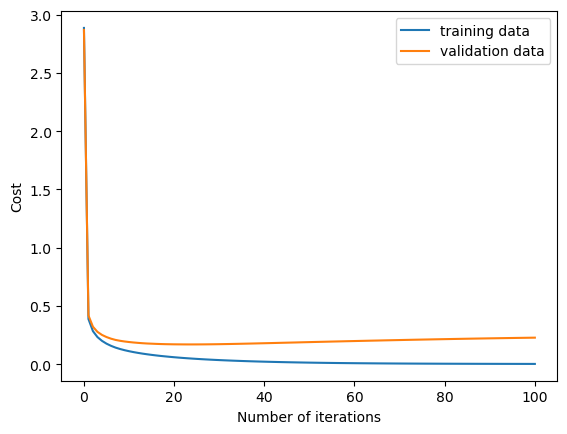

In [109]:
plt.plot(cost_history, label="training data")
plt.plot(val_cost_history, label="validation data")
plt.legend()
plt.xlabel("Number of iterations")
plt.ylabel("Cost")
plt.show()

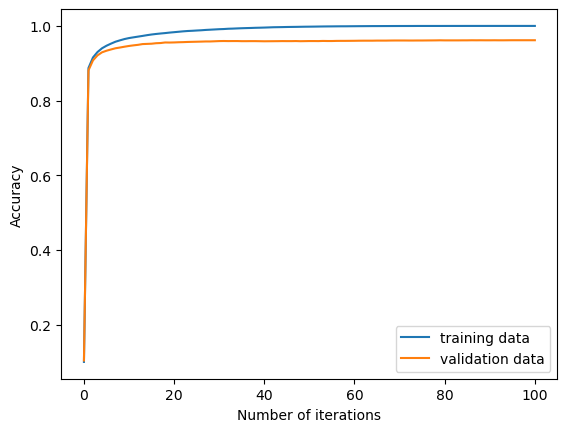

In [110]:
plt.plot([np.sum(np.equal(np.argmax(model(x[:,train_indices], w), axis=0), y[:,train_indices]))/np.size(y[:,train_indices]) for w in weight_history], label="training data")
plt.plot([np.sum(np.equal(np.argmax(model(x[:,val_indices], w), axis=0), y[:,val_indices]))/np.size(y[:,val_indices]) for w in weight_history], label="validation data")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

We can see from the cost and accuracy plots above that we achieve similar results as in the text